# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import pickle


# Dataset

## Obtaining the dataset

In [6]:
# getting the dataset from the csv file
data = pd.read_csv('Lab6-Proj1_Dataset.csv')

In [7]:
data.tail()

,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
280,0.15,18.40,0.01,1.0,6,2.420293
281,0.15,18.40,0.01,1.2,6,2.427482
282,0.18,26.45,0.01,0.9,6,1.690174
283,0.18,26.45,0.01,1.0,6,1.707076
284,0.18,26.45,0.01,1.2,6,1.712146


### Statistical Analysis of the dataset  

In [8]:
# shape
print(data.shape)

# quick statistical analysis of the dataset
data.describe()

(285, 6)


,Anchor_Ratio,Transmission_Range,Node_Density,Step_Size,Iterations,ESLE
count,285.000000,285.000000,285.000000,285.000000,285.000000,2.850000e+02
mean,0.207474,20.554737,0.015158,1.033333,37.536842,1.220366e+00
std,0.065472,3.410259,0.006796,0.124941,24.104881,1.536450e+00
min,0.140000,17.250000,0.010000,0.900000,6.000000,8.900000e-08
25%,0.150000,17.250000,0.010000,0.900000,20.000000,7.837210e-01
50%,0.180000,20.700000,0.010000,1.000000,30.000000,1.054853e+00
75%,0.300000,23.000000,0.020000,1.200000,60.000000,1.360695e+00
max,0.300000,28.750000,0.030000,1.200000,90.000000,2.500000e+01


General Boxplot

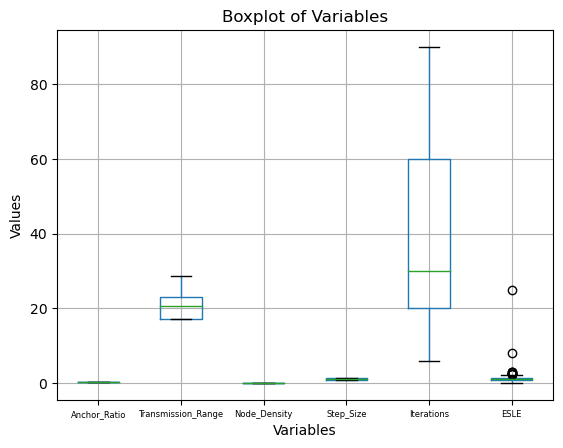

In [9]:
# generating the boxplot
data.boxplot()

# setting the plot title and axes labels
plt.title('Boxplot of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(fontsize=6)

# displaying the plot
plt.show()

Individual Boxplots for better visualization

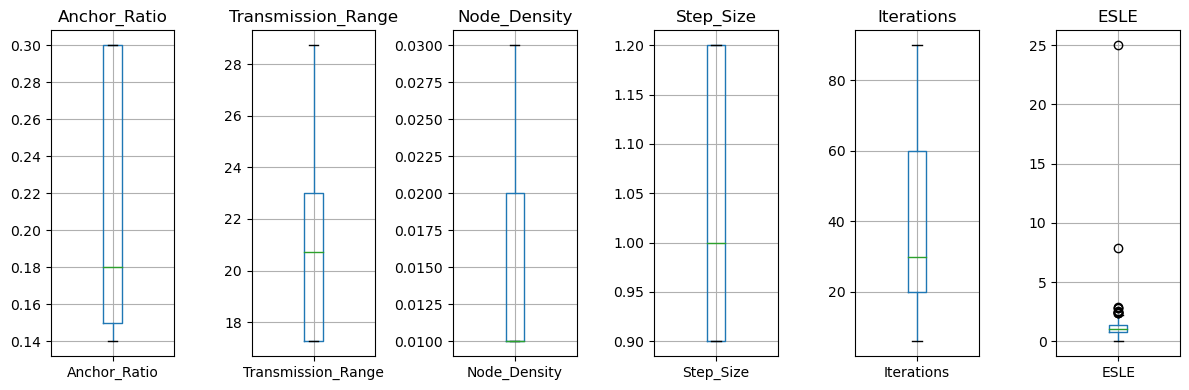

In [10]:
# Determine the number of variables
num_variables = len(data.columns)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_variables, figsize=(12, 4))

# Generate individual boxplots for each variable
for i, column in enumerate(data.columns):
    data.boxplot(column=column, ax=axes[i])
    axes[i].set_title(column)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

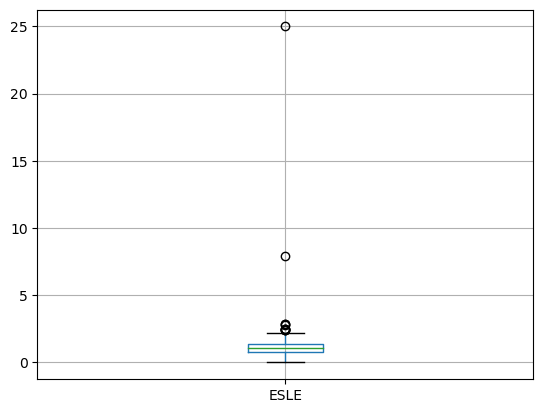

<Figure size 1500x1000 with 0 Axes>

In [11]:
data.boxplot(column='ESLE')

# Display the plot
plt.figure(figsize=(15, 10))
plt.show()

## Data Preprocessing 

### Data Cleaning

- No incomplete data
- Is there noisy data? (no indication for errors, nor outlier, but might there be outliers?)
- No inconsistent data
- Is there intentional data? (certainly doesn't seem like so)

In [12]:
# Verify if there are any missing values
print(data.isnull().sum())

# Boxplot: ends of the box are the quartiles; median is marked; add
# whiskers, and plot outliers individually
# 1.5 x IQR rule
# Calculate the IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Get observations with above or qual to 1.5 x IQR rule
# TODO - check if this is correct ERROR
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)) | (data['Iterations'] < 20))
# Print observations with above or qual to 1.5 x IQR rule 
outliers_to_visualize = data[outliers.any(axis=1)]

# Remove observations with above or qual to 1.5 x IQR rule

Anchor_Ratio          0
Transmission_Range    0
Node_Density          0
Step_Size             0
Iterations            0
ESLE                  0
dtype: int64


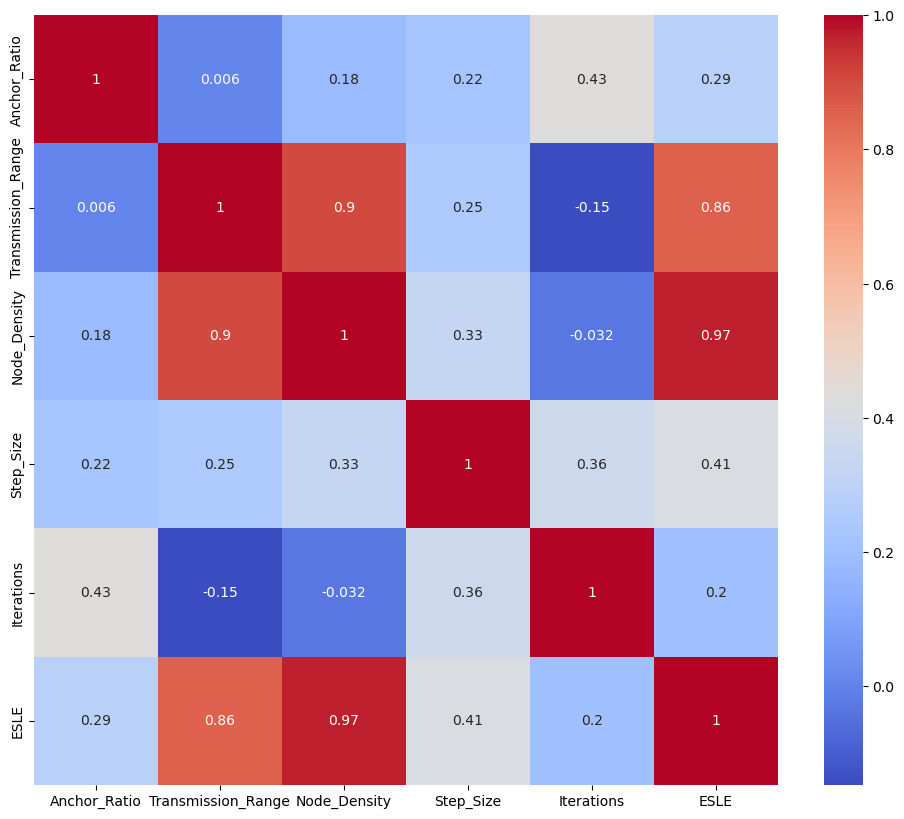

In [13]:

# Calculate correlation matrix for your outliers
corr_matrix = outliers_to_visualize.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Data Integration

- combine data from different sources. are there different sources? (don't think so)
- any different scale / unit problems? (better check)
- any redudant features? (correlation analysis, covariance analysis) (should delve further)

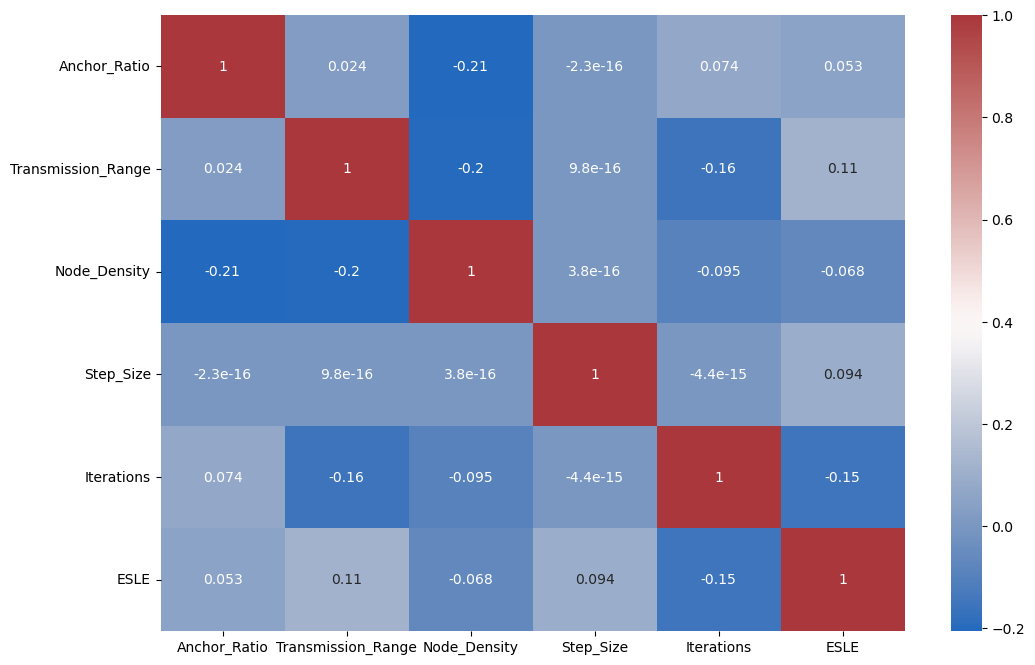

In [14]:
# correlation analysis of the dataset (Pearson's correlation coefficient)
plt.figure(figsize=(12, 8))
# with nice colours, such that 0 always corresponds to white
colour = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=colour)
plt.show()

# other cmap options are: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# a colormap such that 0 always corresponds to white is 'coolwarm', 'bwr', 'seismic'

### Data Reduction

### Data transformation and data discretization

# Creating the models

#### Transform Data

In [15]:
# copy dataset data
data_copy = data.copy()

# split dataset into input and output variables, y is the last column
X = data_copy.iloc[:, :-1]
y = data_copy.iloc[:, -1]

# Define seed for reproducibility
seed = 42

# assuming X and y are your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Ploting data 

In [17]:
# plotting the results
def plot_results(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='blue')
    plt.title('MLP regressor model')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

#### Save Model


In [18]:
def save_model(model, filename):
    # save model
    pickle.dump(model, open(filename, "wb"))

def load_model(filename):
    # load model
    loaded_model = pickle.load(open(filename, "rb"))
    return loaded_model

### MLP 

In [19]:
# Define the model
model = MLPRegressor(activation='logistic', solver='sgd', early_stopping=True,
                     max_iter=200, validation_fraction=0.2, learning_rate='adaptive',
                     batch_size=128, n_iter_no_change=20, tol=1e-4)

# Define the grid of hyperparameters to search
parameter_space = {
    'hidden_layer_sizes': [(10,), (10,5), (10,10), (50,), (100,), (100, 5), (100, 10), (50, 50), (100, 5)],
    'learning_rate_init': [0.0001, 0.001, 0.005, 0.01, 0.1],
    'alpha': [0.0001, 0.001, 0.01]
}

# Set up the grid search 
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5) # cv = number of folds

# Fit the model on the training data
clf.fit(X_train, y_train)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Predict on the test set using the best parameters
y_pred = clf.predict(X_test)

# Root mean squared deviation
print('Root mean squared deviation: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

save_model(clf, 'model.pickle')

/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/pyth

Best parameters found:
 {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
-0.061 (+/-0.124) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001}
0.002 (+/-0.063) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001}
-0.301 (+/-0.777) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.005}
-0.207 (+/-0.500) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}
-0.145 (+/-0.372) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1}
-0.823 (+/-2.836) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.0001}
-0.022 (+/-0.052) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.001}
-0.091 (+/-0.207) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.005}
-0.190 (+/-0.730) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.01}
-0.051 (+/-0.

/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
loaded_model = load_model('model.pickle')

# Predict on the test set using the best parameters
y_pred = loaded_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

Mean squared error:  0.18144314251027455


In [21]:
# create MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(100,5), 
                     activation='logistic', 
                     solver='sgd', 
                     early_stopping=True,
                     max_iter=200,
                     validation_fraction=0.2, 
                     learning_rate = 'adaptive',
                     batch_size=128,
                     n_iter_no_change=20, tol=1e-4)

mse_mean = []
r2_mean = []

for i in range(100):

    # train the model
    model.fit(X_train, y_train)

    # predict on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    mse_mean.append(mse)
    r2_mean.append(r2_score(y_test, y_pred))
    #print(f"Mean Squared Error on Test Data: {mse}")

    #print('Coefficient of determination (regression score function): %.2f' % r2_score(y_test, y_pred))
print(f"Mean Squared Error on Test Data: {np.mean(mse_mean)}")
print(f"R2 score on Test Data: {np.mean(r2_mean)}")
#plot_results(y_test, y_pred)


/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gustavo/anaconda3/lib/pyth

Mean Squared Error on Test Data: 0.18139916174589513
R2 score on Test Data: -0.02821580701280216


### CNN

In [22]:
# reshape the data to 3D for CNN input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the model
model = Sequential()
model.add(Conv1D(32, 2, activation='sigmoid', input_shape=(X_train_cnn.shape[1], 1)))
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mse'])

mse_mean_cnn = []

for i in range(100):

    # Fit the model
    history = model.fit(X_train_cnn, 
                        y_train, 
                        validation_split=0.2, 
                        epochs=100, 
                        batch_size=128, 
                        verbose=0, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

    # Predict on the test data
    y_pred = model.predict(X_test_cnn)

    # calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_mean_cnn.append(mse)
    #print(f"Mean Squared Error on Test Data: {mse}")

print(f"Mean Squared Error on Test Data: {np.mean(mse_mean_cnn)}")

"""
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
"""

2023-05-26 17:24:43.038405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 17:24:43.042233: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2/2 [==============================] - 0s 6ms/step
Mean Squared Error on Test Data: 0.3178794519330877


"\n# plot training and validation loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Validation'], loc='upper right')\nplt.show()\n"

### RNN